In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from IPython import display
import json

from collections import defaultdict

from sklearn.datasets import load_boston, make_classification
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold

from qpfs import QPFS
from optimization import RegGD, RegNM, RegADAM, RegGN
from optimization import ClassGD, ClassNM, ClassADAM, ClassIRLS
from load_data import *

plt.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'
cmap = sns.light_palette((210, 90, 60), 10, input="husl")
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20

In [2]:
def nearest_point(x, y, X_grid, Y_grid):
    return np.argmin((Y_grid - y) ** 2), np.argmin((X_grid - x) ** 2)

In [3]:
def plot_w_updates(self, figsize):
        df = np.zeros((np.prod(self.W1.shape), len(self._w_history) - 1))
        for i in range(len(self._w_history) - 1):
            w_prev = self._w_history[i][0].ravel()
            w_next = self._w_history[i + 1][0].ravel()
            df[:, i] = np.abs(w_next - w_prev) > 1e-12

        df = pd.DataFrame(df)

        plt.figure(figsize=figsize)
        sns.heatmap(df, cmap=cmap, vmin=0., vmax=1., cbar=False)
        plt.ylabel('parameters')
        plt.xlabel('iteration')
        plt.tight_layout()
        plt.savefig('figs/active_params_wrt_iters.eps', format='eps')
        plt.show()

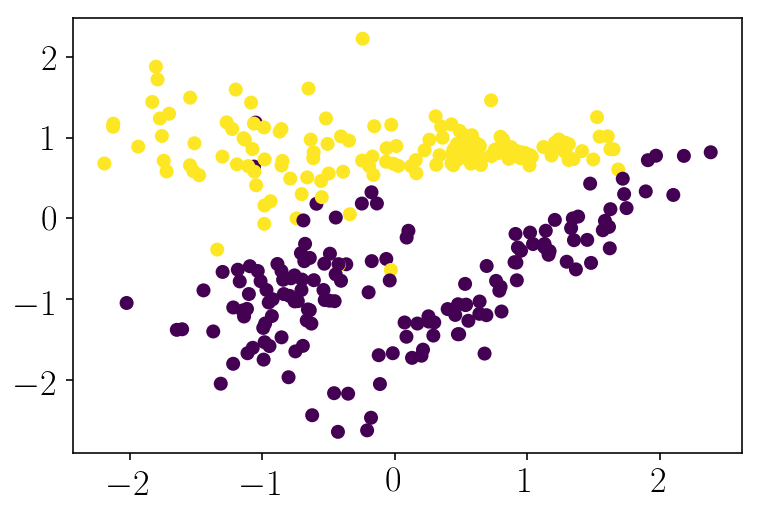

In [3]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, random_state=28)
X = (X - X.mean(0)) / X.std(axis=0)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [4]:
lr = LogisticRegression(C=7., fit_intercept=False)
lr.fit(X, y)
W_true = lr.coef_
np.random.seed(40)
W_near = W_true + 1. * np.random.randn(*W_true.shape)

In [5]:
irls = ClassIRLS(add_bias=False, qpfs=True, max_iter=30)

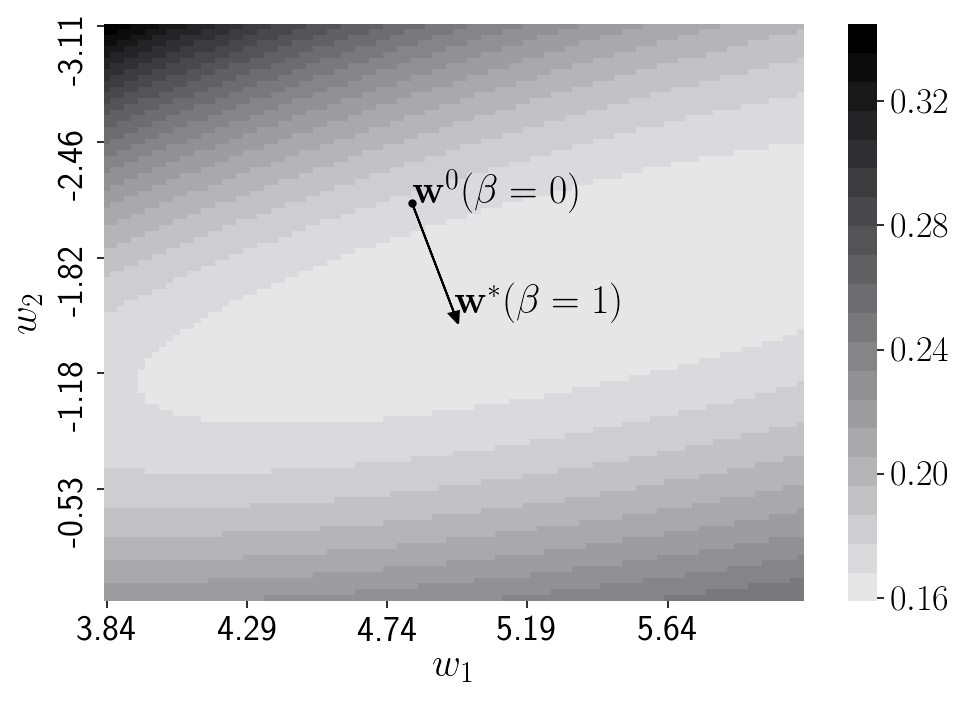

In [6]:
dw1, dw2 = np.abs(W_near - W_true).squeeze() + 1
i1, i2 = 0, 1
k_grid = 100

i1_x, i1_y = i1 // W_true.shape[1], i1 %  W_true.shape[1]
i2_x, i2_y = i2 // W_true.shape[1], i2 %  W_true.shape[1]
Z_grid = np.zeros((k_grid, k_grid))
X_grid = [W_true[i1_x, i1_y] - dw1 + 2 * i * dw1 / k_grid for i in range(k_grid)]
Y_grid = [W_true[i2_x, i2_y] - dw2 + 2 * j * dw2 / k_grid for j in range(k_grid)]

for i, x_ in enumerate(X_grid):
    for j, y_ in enumerate(Y_grid):
        W = np.array([x_, y_])
        Z_grid[i, j] = log_loss(y, irls.sigmoid(X.dot(W)))
        
Z_grid = pd.DataFrame(Z_grid, columns=[np.round(y_, 2) for y_ in Y_grid], index=[np.round(x_, 2) for x_ in X_grid])

plt.figure(figsize=(7, 5))
sns.heatmap(Z_grid, cmap=sns.cubehelix_palette(20, hue=0.05, rot=0, light=0.9, dark=0), xticklabels=20, yticklabels=20)
idx_W_true = nearest_point(W_true[i1_x, i1_y], W_true[i2_x, i2_y], X_grid, Y_grid)
idx_W_near = nearest_point(W_near[i1_x, i1_y], W_near[i2_x, i2_y], X_grid, Y_grid)
plt.scatter(*idx_W_near, c='k', s=10)
plt.arrow(*idx_W_near, *[x1 - x2 for x1, x2 in zip(idx_W_true, idx_W_near)], 
          head_width=1.5, head_length=2., fc='k', ec='k')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.text(*idx_W_near, r'$\mathbf{w}^0 (\beta=0)$', fontsize=20)
plt.text(*idx_W_true, r'$\mathbf{w}^* (\beta=1)$', fontsize=20)

plt.tight_layout()
#plt.savefig('figs/log_reg_error.eps', format='eps')
plt.show()

In [7]:
X, y = make_classification(n_samples=300, n_features=7, n_redundant=5, random_state=30)
X = (X - X.mean(0)) / X.std(axis=0)

lr = LogisticRegression(C=10000., fit_intercept=False)
lr.fit(X, y)
W_true = lr.coef_
np.random.seed(40)
W_near = W_true + 1. * np.random.randn(*W_true.shape)

In [8]:
irls = ClassIRLS(add_bias=False, qpfs=True, max_iter=30)

irls.fit(X, y)

iter: 0, acc: 0.64, loss: 0.5274
	 0.283 0.201 0.000 0.204 0.000 0.000 0.311
	 b:0.563 0.584 0.679 0.624 0.068 0.698 0.600
	 cond before: 42768084546386440.000, cond after: 11899.709
	 t: 0.8000

iter: 1, acc: 0.91, loss: 0.2952
	 0.216 0.186 0.072 0.222 0.000 0.019 0.284
	 b:0.266 0.284 0.513 0.478 0.110 0.521 0.460
	 cond before: 160973303421330496.000, cond after: 11140.837
	 t: 1.0000

iter: 2, acc: 0.93, loss: 0.2223
	 0.147 0.196 0.235 0.217 0.000 0.151 0.054
	 b:0.105 0.113 0.257 0.231 0.050 0.264 0.219
	 cond before: 32685893660054284.000, cond after: 4548.104
	 t: 1.0000

iter: 3, acc: 0.93, loss: 0.2008
	 0.179 0.137 0.461 0.000 0.000 0.223 0.000
	 b:0.020 0.022 0.076 0.067 0.019 0.078 0.063
	 cond before: 37903040356030680.000, cond after: 2875.884
	 t: 0.8000

iter: 4, acc: 0.93, loss: 0.1974
	 0.003 0.224 0.469 0.000 0.000 0.304 0.000
	 b:0.000 0.001 0.031 0.028 0.013 0.031 0.027
	 cond before: 170052847702391520.000, cond after: 1219.855
	 t: 0.8000

iter: 5, acc: 0.94, l

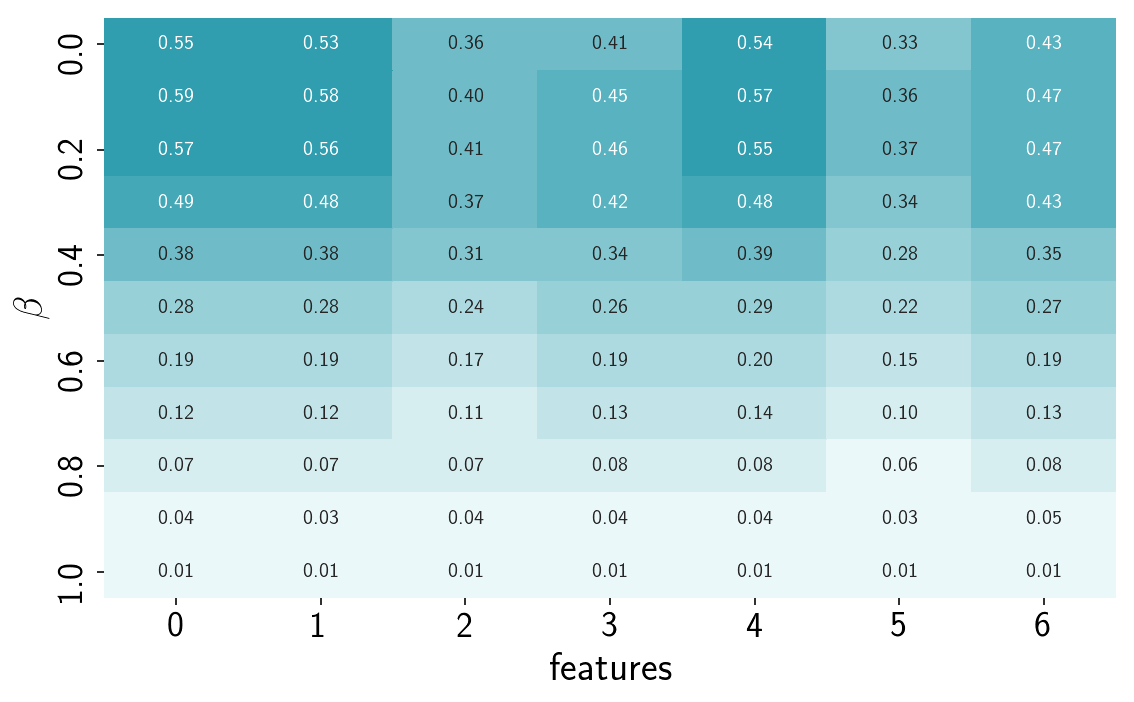

In [9]:
aff_coeffs = np.linspace(0, 1, 11)
Qs = []
bs = []
irls.verbose = False

for aff_coeff in aff_coeffs:
    W = (aff_coeff * W_true + (1 - aff_coeff) * W_near)
    irls.w = W.squeeze()
    irls._update_weights(X, y)
    bs.append(irls.qpfs.b.squeeze())
    Qs.append(irls.qpfs.Q)
    
plt.figure(figsize=(8, 5))
bs = pd.DataFrame(np.array(bs), index=aff_coeffs)
sns.heatmap(bs, cmap=cmap, cbar=False, yticklabels=2, annot=True, fmt='.2f')
plt.xlabel('features')
plt.ylabel(r'$\beta$')

plt.tight_layout()
plt.show()

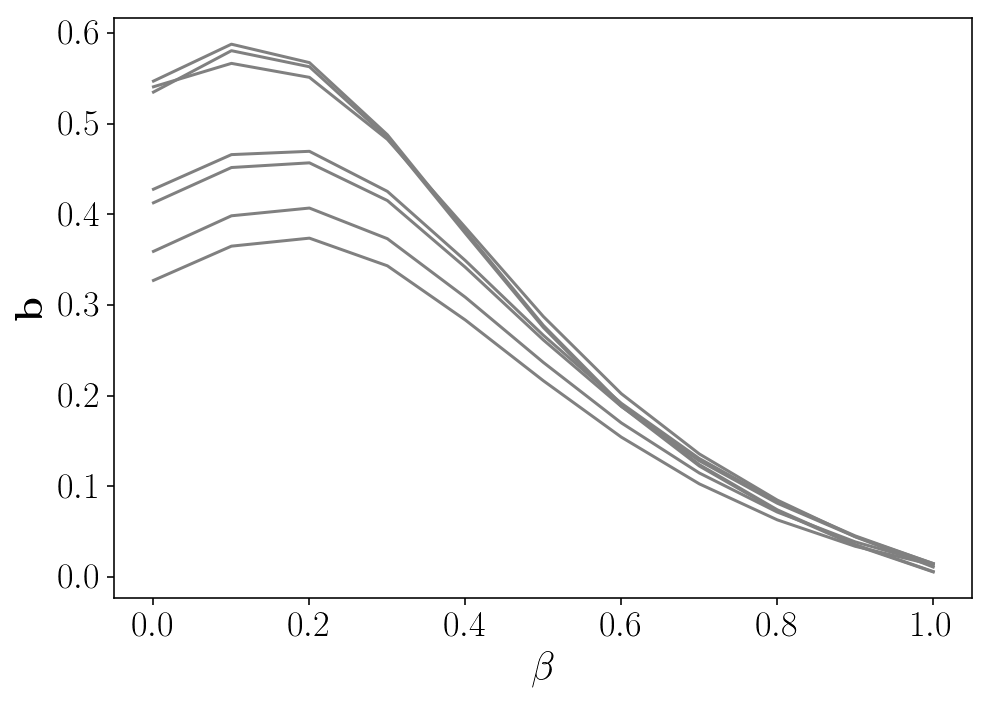

In [10]:
plt.figure(figsize=(7, 5))
plt.plot(bs, c='gray')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\mathbf{b}$')
plt.tight_layout()
plt.savefig('figs/log_reg_b_wrt_beta.eps', format='eps')
plt.show()

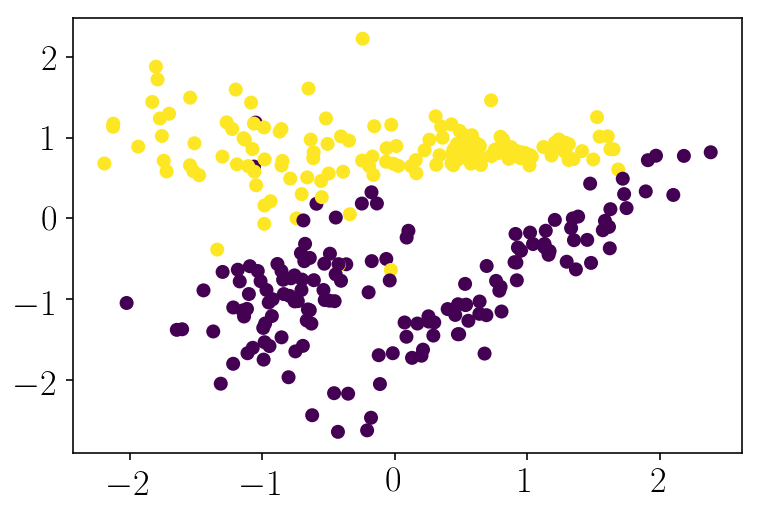

In [11]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, random_state=28)
X = (X - X.mean(0)) / X.std(axis=0)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [12]:
lr = LogisticRegression(fit_intercept=False, C=7.)
lr.fit(X, y)
y_pred = lr.predict(X)
print(np.mean(y == y_pred))
W_true = lr.coef_.squeeze()

0.953333333333


iter: 0, acc: 0.89, loss: 0.3837
	 0.396 0.604
	 b:0.281 0.599
	 cond before: 1.381, cond after: 1.381
	 t: 1.0000

iter: 1, acc: 0.94, loss: 0.2308
	 0.255 0.745
	 b:0.125 0.393
	 cond before: 2.633, cond after: 2.632
	 t: 1.0000

iter: 2, acc: 0.94, loss: 0.1773
	 0.000 1.000
	 b:0.025 0.141
	 cond before: 1.000, cond after: 1.000
	 t: 0.8000

iter: 3, acc: 0.94, loss: 0.1706
	 0.516 0.484
	 b:0.058 0.056
	 cond before: 5.250, cond after: 5.241
	 t: 0.8000

iter: 4, acc: 0.94, loss: 0.1610
	 0.000 1.000
	 b:0.002 0.027
	 cond before: 1.000, cond after: 1.000
	 t: 0.8000

iter: 5, acc: 0.94, loss: 0.1607
	 0.000 1.000
	 b:0.003 0.018
	 cond before: 1.000, cond after: 1.000
	 t: 1.0000

iter: 6, acc: 0.94, loss: 0.1607
	 0.000 1.000
	 b:0.005 0.016
	 cond before: 1.000, cond after: 1.000
	 t: 1.0000



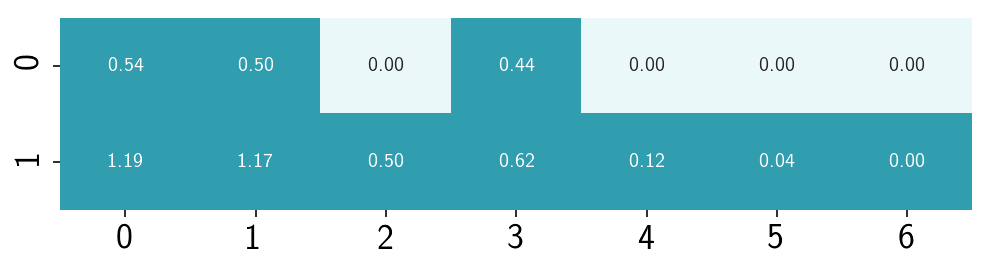

In [13]:
np.random.seed(53)
irls = ClassIRLS(add_bias=False, qpfs=True, max_iter=50)
irls.fit(X, y)
irls.plot_w_updates((7, 2))

In [14]:
irls._w_history = [np.array([ 1.,  8.]),
 np.array([ 1.        ,  6.48274639]),
 np.array([-0.67897823,  6.48274639]),
 np.array([-1.13787791,  4.78396916]),
 np.array([-1.33691523,  4.78396916]),
 np.array([-1.33691523,  4.86693613]),
 np.array([-1.33691523,  4.8862326 ]),
 np.array([-1.33691523,  4.89023463])]

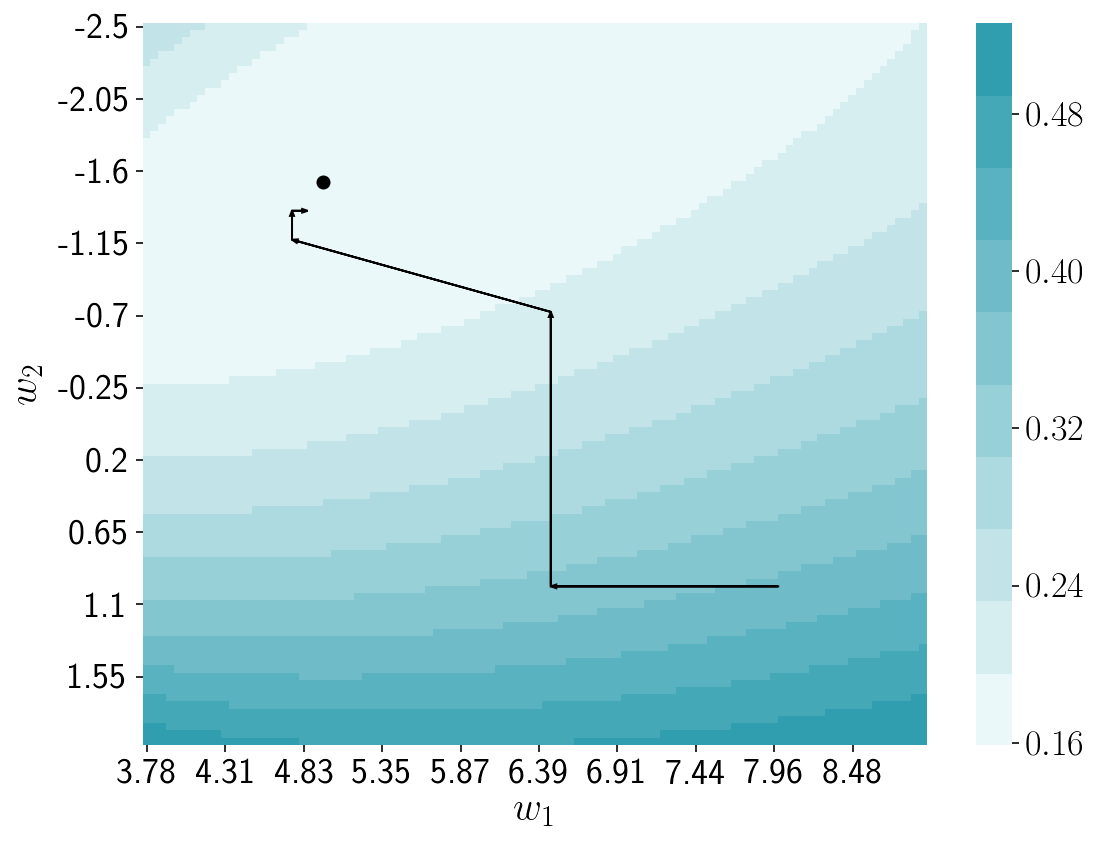

In [15]:
w1_min, w1_max = np.min([w[0] for w in irls._w_history]), np.max([w[0] for w in irls._w_history])
w2_min, w2_max = np.min([w[1] for w in irls._w_history]), np.max([w[1] for w in irls._w_history])

dw1_x, dw1_y = min(W_true[0], w1_min) - 1, max(W_true[0], w1_max) + 1
dw2_x, dw2_y = min(W_true[1], w2_min) - 1, max(W_true[1], w2_max) + 1
k_grid = 100

Z_grid = np.zeros((k_grid, k_grid))
X_grid = [dw1_x + i * (dw1_y - dw1_x) / k_grid for i in range(k_grid)]
Y_grid = [dw2_x + j * (dw2_y - dw2_x) / k_grid for j in range(k_grid)]

for i, x_ in enumerate(X_grid):
    for j, y_ in enumerate(Y_grid):
        W = np.array([x_, y_])
        y_pred = irls.sigmoid(X.dot(W))
        Z_grid[i, j] = log_loss(y, y_pred)
        
Z_grid = pd.DataFrame(Z_grid, columns=[np.round(y_, 2) for y_ in Y_grid], index=[np.round(x_, 2) for x_ in X_grid])

plt.figure(figsize=(8, 6))
sns.heatmap(Z_grid, cmap=cmap, xticklabels=10, yticklabels=10)
idx_W_true = nearest_point(W_true[0], W_true[1], X_grid, Y_grid)
plt.scatter(*idx_W_true, c='k')
idx_W_prev = nearest_point(irls._w_history[0][0], irls._w_history[0][1], X_grid, Y_grid)
for i in range(len(irls._w_history) - 1):
    idx_W_next = nearest_point(irls._w_history[i + 1][0], irls._w_history[i + 1][1], X_grid, Y_grid)
    arx, ary = idx_W_prev
    darx, dary = [x1 - x2 for x1, x2 in zip(idx_W_next, idx_W_prev)]
    if (darx != 0) or (dary != 0):
        plt.arrow(arx, ary, darx, dary, head_width=.5, head_length=.7, fc='k', ec='k', length_includes_head=True)
    idx_W_prev = idx_W_next
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')

plt.tight_layout()
#plt.savefig('figs/irls_qpfs_2d.eps', format='eps')
plt.show()

### Gauss Newton

In [16]:
X, y = load_boston(return_X_y=True)
X = (X - X.mean(axis=0)) / X.std(axis=0)
# X = X[:, :3]

In [27]:
np.random.seed(42)

gn = RegGN(n_hidden=2, add_bias=False, qpfs=False, verbose=False, max_iter=300)
gn.fit(X, y)
print(mean_squared_error(y, gn.predict(X)))

gn = RegGN(n_hidden=2, add_bias=False, qpfs=True, verbose=False, max_iter=300)
gn.fit(X, y)
print(mean_squared_error(y, gn.predict(X)))

19.757406614
17.0199578239


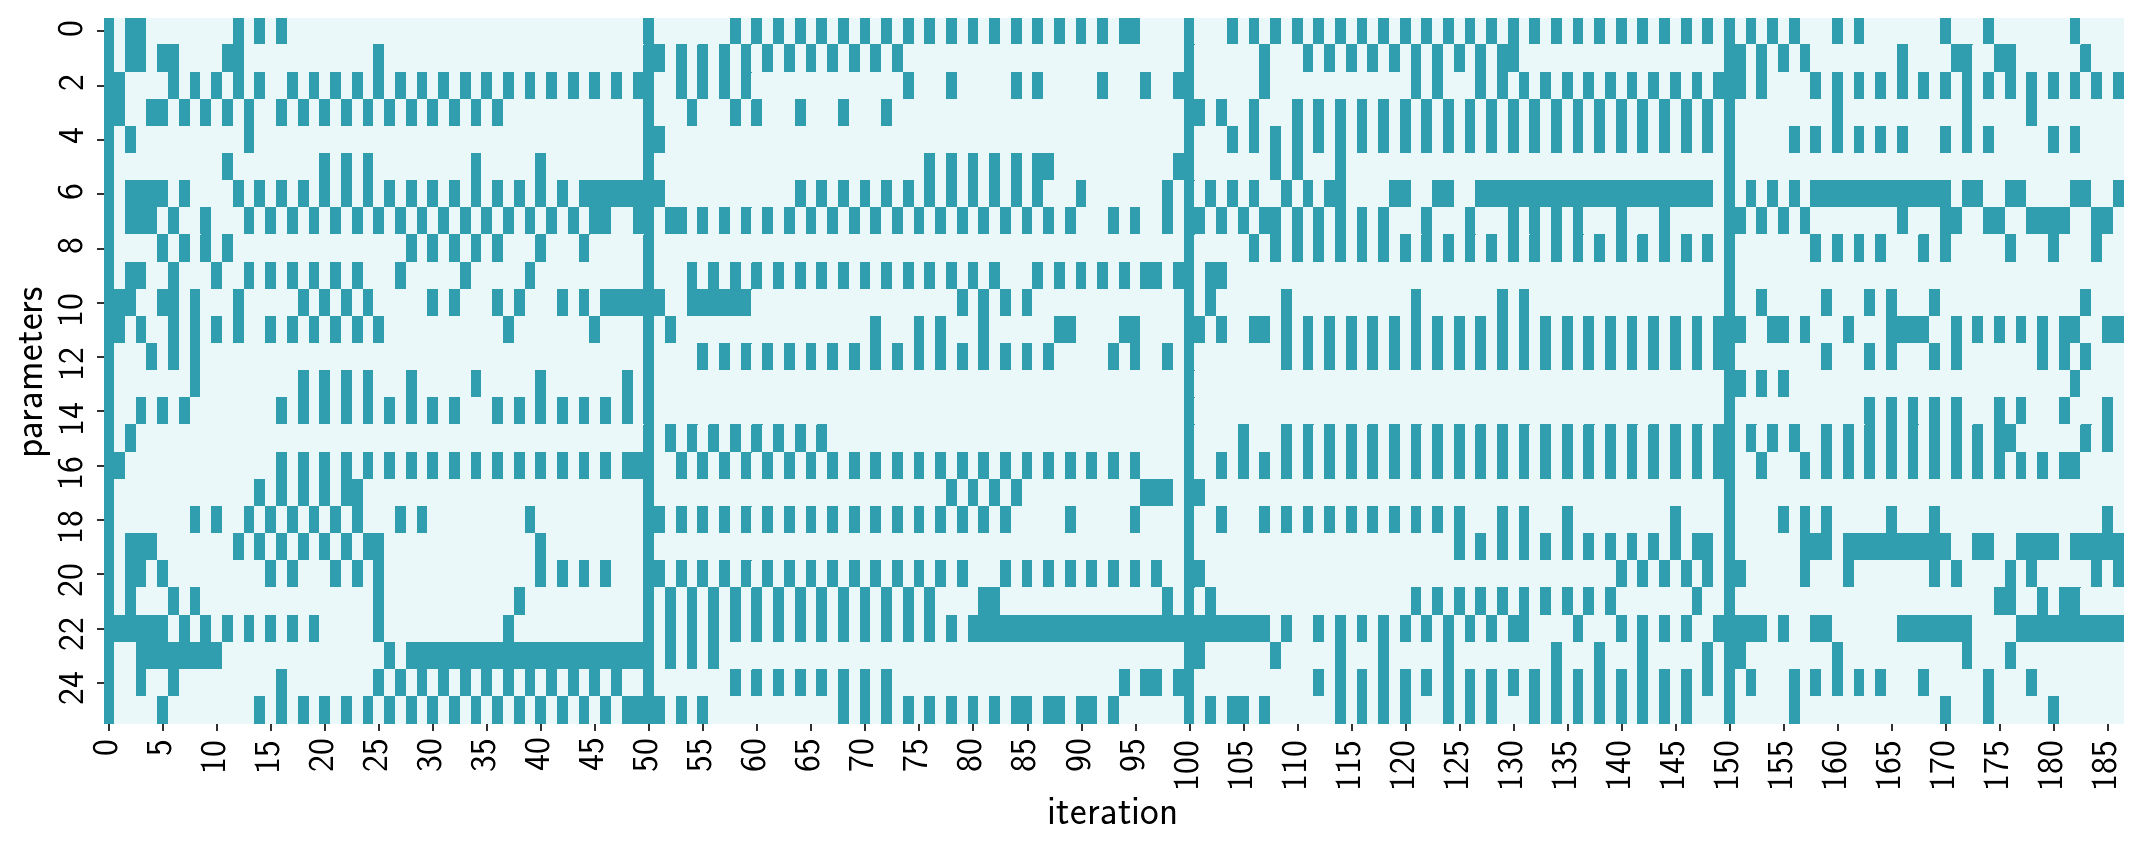

In [28]:
plot_w_updates(gn, figsize=(15, 6))

In [29]:
W1_true = gn.W1
np.random.seed(32)
W1_near = W1_true + .5 * np.random.randn(*W1_true.shape)

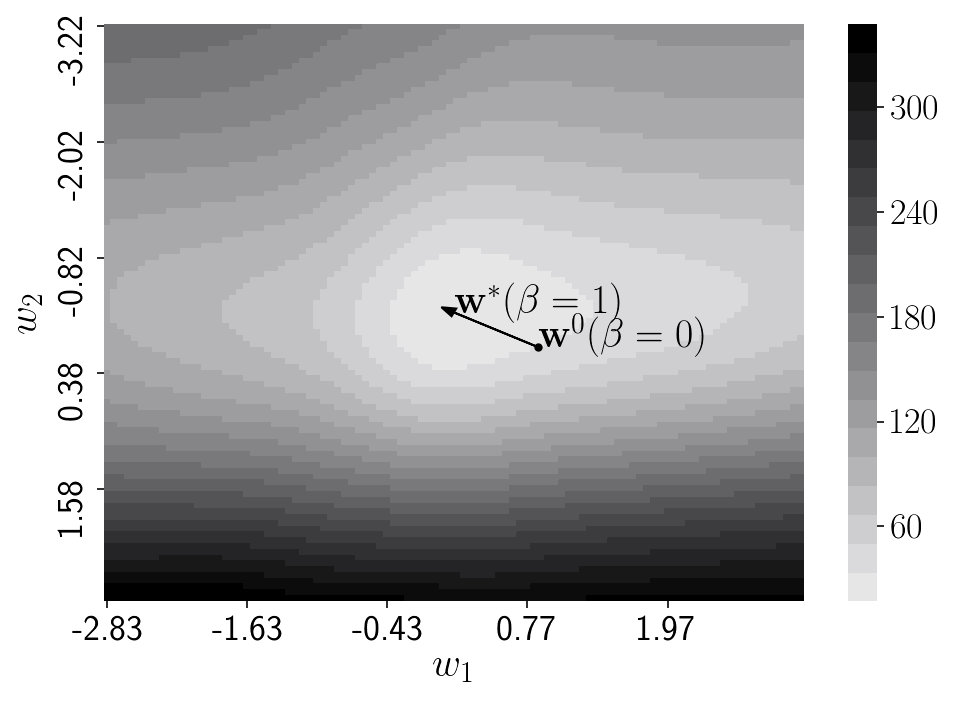

In [30]:
dw1, dw2 = 3., 3.
i1, i2 = 4, 6
k_grid = 100

i1_x, i1_y = i1 // W1_true.shape[1], i1 %  W1_true.shape[1]
i2_x, i2_y = i2 // W1_true.shape[1], i2 %  W1_true.shape[1]
Z_grid = np.zeros((k_grid, k_grid))
X_grid = [W1_true[i1_x, i1_y] - dw1 + 2 * i * dw1 / k_grid for i in range(k_grid)]
Y_grid = [W1_true[i2_x, i2_y] - dw2 + 2 * j * dw2 / k_grid for j in range(k_grid)]

for i, x_ in enumerate(X_grid):
    for j, y_ in enumerate(Y_grid):
        W1 = W1_true.copy()
        W1[i1_x, i1_y] = x_
        W1[i2_x, i2_y] = y_
        Z_grid[i, j] = mean_squared_error(y, gn.sigmoid(X.dot(W1)).dot(gn.W2))
        
Z_grid = pd.DataFrame(Z_grid, columns=[np.round(y_, 2) for y_ in Y_grid], index=[np.round(x_, 2) for x_ in X_grid])

plt.figure(figsize=(7, 5))
sns.heatmap(Z_grid, cmap=sns.cubehelix_palette(20, hue=0.05, rot=0, light=0.9, dark=0), xticklabels=20, yticklabels=20)
idx_W1_true = nearest_point(W1_true[i1_x, i1_y], W1_true[i2_x, i2_y], X_grid, Y_grid)
idx_W1_near = nearest_point(W1_near[i1_x, i1_y], W1_near[i2_x, i2_y], X_grid, Y_grid)
plt.scatter(*idx_W1_near, c='k', s=10)
plt.arrow(*idx_W1_near, *[x1 - x2 for x1, x2 in zip(idx_W1_true, idx_W1_near)], 
          head_width=1.5, head_length=2., fc='k', ec='k')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.text(*idx_W1_near, r'$\mathbf{w}^0 (\beta=0)$', fontsize=20)
plt.text(*idx_W1_true, r'$\mathbf{w}^* (\beta=1)$', fontsize=20)

plt.tight_layout()
#plt.savefig('figs/neural_error.eps', format='eps')
plt.show()

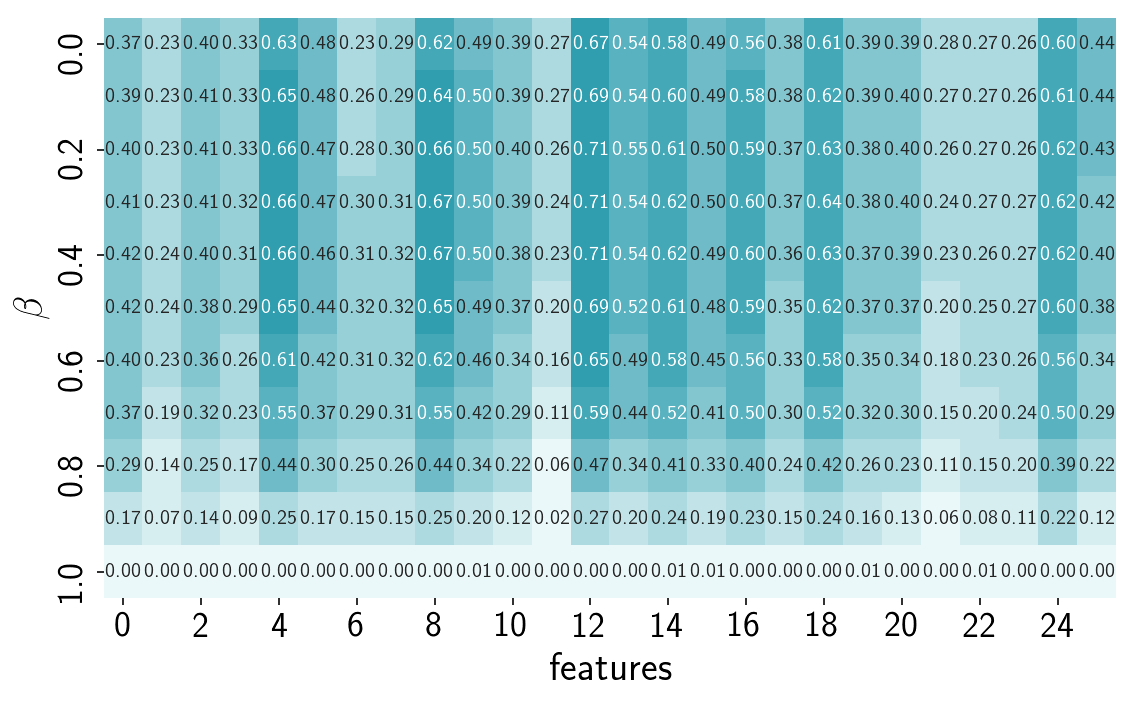

In [31]:
aff_coeffs = np.linspace(0, 1, 11)
Qs = []
bs = []
gn.verbose = False

for aff_coeff in aff_coeffs:
    W1 = (aff_coeff * W1_true + (1 - aff_coeff) * W1_near)
    gn.W1 = W1.squeeze()
    gn._update_weights(X, y, gn.predict(X))
    bs.append(gn.qpfs[0].b.squeeze())
    Qs.append(gn.qpfs[0].Q)
    
plt.figure(figsize=(8, 5))
bs = pd.DataFrame(np.array(bs), index=aff_coeffs)
sns.heatmap(bs, cmap=cmap, cbar=False, yticklabels=2, annot=True, fmt='.2f')
plt.xlabel('features')
plt.ylabel(r'$\beta$')

plt.tight_layout()
plt.show()

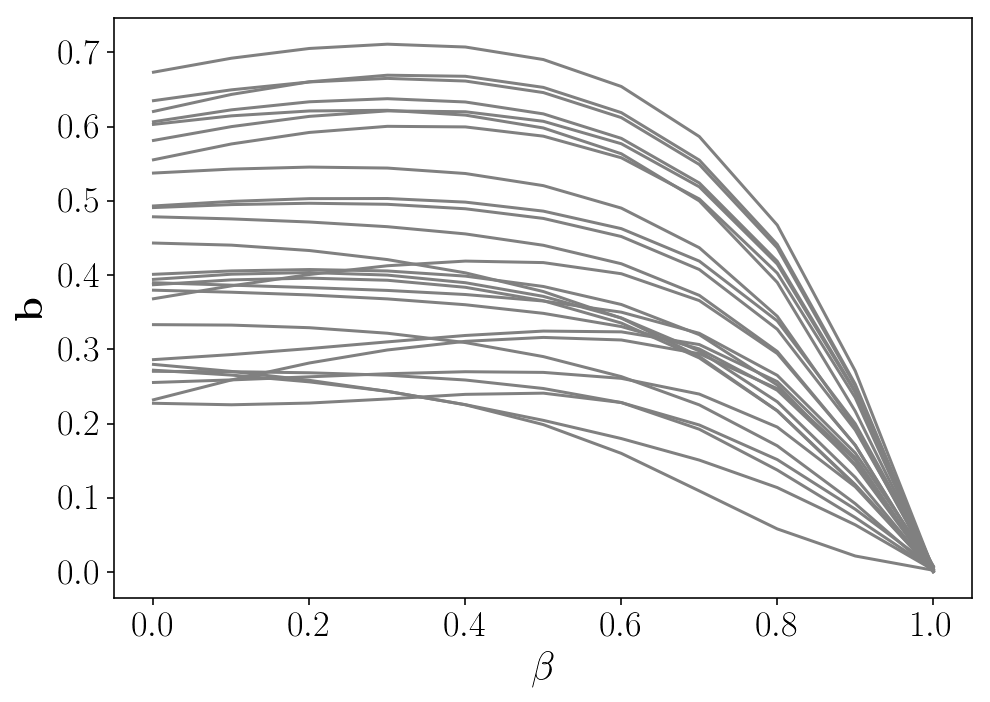

In [32]:
plt.figure(figsize=(7, 5))
plt.plot(bs, c='gray')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\mathbf{b}$')
plt.tight_layout()
#plt.savefig('figs/neural_b_wrt_beta.eps', format='eps')
plt.show()

In [33]:
np.random.seed(42)
gn = RegGN(n_hidden=2, add_bias=True, qpfs=False, verbose=False, max_iter=300)
gn.fit(X, y)
print('Newton: {:.4f}'.format(mean_squared_error(y, gn.predict(X))))
gn = RegGN(n_hidden=2, add_bias=True, qpfs=True, verbose=False, max_iter=300)
gn.fit(X, y)
print('QPFS+Newton: {:.4f}'.format(mean_squared_error(y, gn.predict(X))))

Newton: 23.0322
QPFS+Newton: 28.6693


In [34]:
mlp_sgd = MLPRegressor(hidden_layer_sizes=2, activation='logistic', solver='sgd', learning_rate_init=0.1)
mlp_sgd.fit(X, y)

print('SGD: {:.4f}'.format(mean_squared_error(y, mlp_sgd.predict(X))))

mlp_adam = MLPRegressor(hidden_layer_sizes=2, activation='logistic', solver='adam', learning_rate_init=0.1)
mlp_adam.fit(X, y)

print('ADAM: {:.4f}'.format(mean_squared_error(y, mlp_adam.predict(X))))

mlp_adam = MLPRegressor(hidden_layer_sizes=2, activation='logistic', solver='lbfgs')
mlp_adam.fit(X, y)

print('LBFGS: {:.4f}'.format(mean_squared_error(y, mlp_adam.predict(X))))

SGD: 20.4668
ADAM: 15.8170
LBFGS: 11.3759


### Compare different optimizers (Nonlinear regression)

In [35]:
cv = KFold(n_splits=5, shuffle=True)
datasets = {'boston': load_bostonprices, 
            'community': load_community, 
            'forestfires': load_forestfires, 
            'residentialcost': load_residentialcost, 
            'residentialprice': load_residentialprice}

In [7]:
def get_scores(X, y, estimators, n_restarts, cv, metric, filename=None):
    results = defaultdict(list)
    for n_restart in range(n_restarts):
        for est in estimators:
            for train_idxs, test_idxs in cv.split(X):
                X_train, y_train = X[train_idxs], y[train_idxs]
                X_test, y_test = X[test_idxs], y[test_idxs]

                estimators[est].fit(X_train, y_train)

                pred = estimators[est].predict(X_train)
                results[est + '_' + str(n_restart) + '_' + 'train'].append(metric(y_train, pred))

                pred = estimators[est].predict(X_test)
                results[est + '_' + str(n_restart) + '_' + 'test'].append(metric(y_test, pred))
        print(f'Restart {n_restart} is finished')
    if filename is not None:
        with open(filename, 'w') as f:
            f.write(json.dumps(results))
    return results

In [84]:
estimators = {'gd': RegGD(verbose=False, max_iter=300),
              'nesterov': RegNM(verbose=False, max_iter=300),
              'adam': RegADAM(lr=.1, verbose=False, max_iter=300), 
              'gn': RegGN(n_hidden=2, add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'gn_qpfs': RegGN(n_hidden=2, add_bias=True, qpfs=True, verbose=False, max_iter=300)}

X, y = load_bostonprices()
print(X.shape)
_ = get_scores(X, y, estimators, 5, cv, mean_squared_error, './res/boston.res')

(506, 13)
Restart 0 is finished
Restart 1 is finished
Restart 2 is finished
Restart 3 is finished
Restart 4 is finished


In [86]:
estimators = {'gd': RegGD(verbose=False, max_iter=300),
              'nesterov': RegNM(verbose=False, max_iter=300),
              'adam': RegADAM(lr=.1, verbose=False, max_iter=300), 
              'gn': RegGN(n_hidden=2, add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'gn_qpfs': RegGN(n_hidden=2, add_bias=True, qpfs=True, verbose=False, max_iter=300)}

X, y = load_community()
print(X.shape)
_ = get_scores(X, y, estimators, 5, cv, mean_squared_error, './res/community.res')

(1994, 99)
Restart 0 is finished
Restart 1 is finished
Restart 2 is finished
Restart 3 is finished
Restart 4 is finished


In [ ]:
estimators = {'gd': RegGD(verbose=False, max_iter=300),
              'nesterov': RegNM(verbose=False, max_iter=300),
              'adam': RegADAM(lr=.1, verbose=False, max_iter=300), 
              'gn': RegGN(n_hidden=2, add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'gn_qpfs': RegGN(n_hidden=2, add_bias=True, qpfs=True, verbose=False, max_iter=300)}

X, y = load_forestfires()
print(X.shape)
_ = get_scores(X, y, estimators, 5, cv, mean_squared_error, './res/forestfires.res')

In [ ]:
estimators = {'gd': RegGD(verbose=False, max_iter=300),
              'nesterov': RegNM(verbose=False, max_iter=300),
              'adam': RegADAM(lr=1., verbose=False, max_iter=300), 
              'gn': RegGN(n_hidden=2, add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'gn_qpfs': RegGN(n_hidden=2, add_bias=True, qpfs=True, verbose=False, max_iter=300)}

X, y = load_residentialcost()
print(X.shape)
_ = get_scores(X, y, estimators, 5, cv, mean_squared_error, './res/residentialcost.res')

In [89]:
estimators = {'gd': RegGD(verbose=False, max_iter=300),
              'nesterov': RegNM(verbose=False, max_iter=300),
              'adam': RegADAM(lr=.1, verbose=False, max_iter=300), 
              'gn': RegGN(n_hidden=2, add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'gn_qpfs': RegGN(n_hidden=2, add_bias=True, qpfs=True, verbose=False, max_iter=300)}

X, y = load_residentialprice()
_ = get_scores(X, y, estimators, 5, cv, mean_squared_error, './res/residentialprice.res')

Restart 0 is finished
Restart 1 is finished
Restart 2 is finished
Restart 3 is finished
Restart 4 is finished


### Results

In [ ]:
estimators = {'gd': RegGD(verbose=False, max_iter=300),
              'nesterov': RegNM(verbose=False, max_iter=300),
              'adam': RegADAM(lr=.1, verbose=False, max_iter=300), 
              'gn': RegGN(n_hidden=2, add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'gn_qpfs': RegGN(n_hidden=2, add_bias=True, qpfs=True, verbose=False, max_iter=300)}

files = [
         './res/boston.res', 
         './res/community.res', 
         './res/forestfires.res', 
         './res/residentialcost.res', 
         './res/residentialprice.res'
        ]

for file in files:
    print(file)
    with open(file, 'r') as f:
        results = json.loads(f.read())
    for est in estimators:
        for r in range(5):
            key = est + '_' + str(r) + '_'
            print(' \t {} {} train {:.4f}+-{:.4f}'.format(est, r, 
                                                    np.mean(results[key + 'train']), np.std(results[key + 'train'])), end=' ')
            print('{} {} test {:.4f}+-{:.4f}'.format(est, r, 
                                                    np.mean(results[key + 'test']), np.std(results[key + 'test'])))

### Compare different optimizers (Classification)

In [75]:
cv = KFold(n_splits=5, shuffle=True)
datasets = {'breast': load_breast, 
            'cardiotocography': load_cardiotocography, 
            'climate': load_climate}

In [76]:
estimators = {'gd': ClassGD(verbose=False, max_iter=300),
              'nesterov': ClassNM(verbose=False, max_iter=300),
              'adam': ClassADAM(lr=1e-2, verbose=False, max_iter=300), 
              'irls': ClassIRLS(add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'irls_qpfs': ClassIRLS(add_bias=True, qpfs=True, verbose=False, max_iter=300)}

X, y = load_breast()
print(X.shape)
res = get_scores(X, y, estimators, 5, cv, log_loss, './res/breast.res')

(569, 30)
Restart 0 is finished
Restart 1 is finished
Restart 2 is finished
Restart 3 is finished
Restart 4 is finished


In [90]:
estimators = {'gd': ClassGD(verbose=False, max_iter=300),
              'nesterov': ClassNM(verbose=False, max_iter=300),
              'adam': ClassADAM(lr=1e-2, verbose=False, max_iter=300), 
              'irls': ClassIRLS(add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'irls_qpfs': ClassIRLS(add_bias=True, qpfs=True, verbose=False, max_iter=300)}

X, y = load_cardiotocography()
print(X.shape)
res = get_scores(X, y, estimators, 5, cv, log_loss, './res/cardiotocography.res')

(2126, 21)
Restart 0 is finished
Restart 1 is finished
Restart 2 is finished
Restart 3 is finished
Restart 4 is finished


In [91]:
estimators = {'gd': ClassGD(verbose=False, max_iter=300),
              'nesterov': ClassNM(verbose=False, max_iter=300),
              'adam': ClassADAM(lr=1e-2, verbose=False, max_iter=300), 
              'irls': ClassIRLS(add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'irls_qpfs': ClassIRLS(add_bias=True, qpfs=True, verbose=False, max_iter=300)}

X, y = load_climate()
print(X.shape)
res = get_scores(X, y, estimators, 5, cv, log_loss, './res/climate.res')

(540, 18)
Restart 0 is finished
Restart 1 is finished
Restart 2 is finished
Restart 3 is finished
Restart 4 is finished


In [97]:
estimators = {'gd': ClassGD(verbose=False, max_iter=300),
              'nesterov': ClassNM(verbose=False, max_iter=300),
              'adam': ClassADAM(lr=1e-2, verbose=False, max_iter=300), 
              'irls': ClassIRLS(add_bias=True, qpfs=False, verbose=False, max_iter=300),
              'irls_qpfs': ClassIRLS(add_bias=True, qpfs=True, verbose=False, max_iter=300)}

files = [
         './res/breast.res', 
         './res/cardiotocography.res', 
         './res/climate.res'
        ]

for file in files:
    print(file)
    with open(file, 'r') as f:
        results = json.loads(f.read())
    for est in estimators:
        for r in range(5):
            key = est + '_' + str(r) + '_'
            print(' \t {} {} train {:.4f}\pm{:.4f}'.format(est, r, 
                                                    np.mean(results[key + 'train']), np.std(results[key + 'train'])), end=' ')
            print('{} {} test {:.4f}\pm{:.4f}'.format(est, r, 
                                                    np.mean(results[key + 'test']), np.std(results[key + 'test'])))

./res/breast.res
 	 gd 0 train 0.0609\pm0.0092 gd 0 test 0.0844\pm0.0424
 	 gd 1 train 0.0614\pm0.0134 gd 1 test 0.0855\pm0.0557
 	 gd 2 train 0.0627\pm0.0063 gd 2 test 0.0882\pm0.0236
 	 gd 3 train 0.0627\pm0.0062 gd 3 test 0.1138\pm0.0626
 	 gd 4 train 0.0638\pm0.0066 gd 4 test 0.0905\pm0.0461
 	 nesterov 0 train 0.0398\pm0.0117 nesterov 0 test 0.1020\pm0.0665
 	 nesterov 1 train 0.0396\pm0.0068 nesterov 1 test 0.1559\pm0.0671
 	 nesterov 2 train 0.0391\pm0.0059 nesterov 2 test 0.1446\pm0.0697
 	 nesterov 3 train 0.0390\pm0.0069 nesterov 3 test 0.1503\pm0.1361
 	 nesterov 4 train 0.0382\pm0.0113 nesterov 4 test 0.1634\pm0.1225
 	 adam 0 train 0.0912\pm0.0278 adam 0 test 0.1269\pm0.0453
 	 adam 1 train 0.0815\pm0.0144 adam 1 test 0.1088\pm0.0569
 	 adam 2 train 0.0911\pm0.0235 adam 2 test 0.1145\pm0.0650
 	 adam 3 train 0.0798\pm0.0169 adam 3 test 0.1155\pm0.0201
 	 adam 4 train 0.0856\pm0.0277 adam 4 test 0.1096\pm0.0353
 	 irls 0 train 0.0217\pm0.0091 irls 0 test 0.2489\pm0.2132
 	 

In [96]:
results

{'adam_0_test': [0.1505688682811975,
  0.13946626073760848,
  0.15506273830616135,
  0.03681874919994441,
  0.15250069078145287],
 'adam_0_train': [0.09774218468290076,
  0.05706122802567743,
  0.13509977574364518,
  0.06566469748464343,
  0.10028770201823585],
 'adam_1_test': [0.10549595705922284,
  0.21073357068852075,
  0.052566602226992595,
  0.05808803658151978,
  0.1172632582970136],
 'adam_1_train': [0.07534597986651358,
  0.06688830876175635,
  0.06850978968078096,
  0.10332866552300407,
  0.0936125321464455],
 'adam_2_test': [0.06531065482386983,
  0.12653525172450603,
  0.08919792806650849,
  0.056454532804239274,
  0.2350227271062505],
 'adam_2_train': [0.09653581055217637,
  0.07530281218108678,
  0.1331035901394752,
  0.06491279745669272,
  0.08575516062984154],
 'adam_3_test': [0.13658489479310548,
  0.1303412011663231,
  0.1097885111378604,
  0.12116500453014999,
  0.07955196658727755],
 'adam_3_train': [0.07004947816196133,
  0.10819171501338529,
  0.09002951657235904,
